# Social Computing/Social Gaming - Summer 2022

# Exercise Sheet 5: Climate Change & NLP
Climate change dominates political debattes, already dramatically affects environments all over the world and will be biggest and most complex challenges in the years to come for humanity.
The goal of this exercise is to analyse the toxicity/controversy of different subtopics of climate change. In order to do so, we will take a look at topic models, text classification and sentiment analysis.
This notebook will guide you through this exercise and explain the different concepts and techniques in more detail.

Execute the following code cell to install the needed libraries for this exercise.

In [1]:
!pip install -q -U tensorflow-text==2.7.3
!pip install -q tf-models-official==2.7.0
!pip install bertopic
!pip install gensim

In [2]:
import tensorflow_text as text
import tensorflow_hub as hub
import gensim.downloader
import tensorflow as tf
import pandas as pd
import numpy as np
import statistics
import sklearn
import gensim
import string
import scipy
import nltk
import re

from sklearn.model_selection import train_test_split

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from tensorflow import keras

from official.nlp import optimization

from bertopic import BERTopic

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\usertest\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\usertest\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 5.0 The Data
The dataset we will be using consists of tweets related to climate change. The tweets were pulled directly from Twitter using their own TwitterAPI. The tweets were selected by searching for different climate related hashtags, such as #climatechange, #actonclimate, #climatehoax, etc. The data used in this project was gathered around the COP26 in Glasgow and a few days prior to the US presidential election of 2020.

The dataset consists of ~14,000 tweets, from which ~2000 tweets were labeled.

Tweets were labled as 'Activist' if the tweet information about the negative effects of climate change, or to act on climate change. Tweets got labled as 'Denier' if the content of the tweet questions the existens of climate change. And 'Neutral' if the tweet was neither 'Activist' nor 'Denier'

### Why Twitter/Tweets?

The continued growth of online social networks and micro-blogging Web services, such as Twitter, enable an extensive and near real-time data source through which the analysis of hateful and antagonistic responses to “trigger” events can be undertaken. Such data affords researchers with the possibility to measure the online social mood and emotion following large-scale, disruptive, and emotive events. Twitter is a defensible and logical source of data for such analysis given that users of social media are more likely to express emotional content due to deindividuation (anonymity, lack of self-awareness in groups, disinhibition) [1]

### 5.0.1 Climate Data
Before we can begin with our analysis, we have to load and preprocess the data.

In [3]:
# load the data
df = pd.read_csv("climate_tweets.csv")

For training we will have to encode the labels as vectors.

In [4]:
def label_to_vector(label):
    if label == "activist":
        return (1,0,0)
    elif label == "neutral":
        return (0,1,0)
    elif label == "denier":
        return (0,0,1)

labels = [label_to_vector(label) for label in df.label]

df["label"] = labels

df.head()

,Unnamed: 0,text,label
0,0,law enforcement called these intimidation tact...,None
1,1,without our forests we will be dragged well be...,None
2,2,"more pcs are getting windows 11, is yours next...",None
3,3,this is what unelected @potus want 🇺🇸 on the g...,"(0, 1, 0)"
4,4,“..a..notorious switch to sunderland where an ...,None


We will remove punctuation and certain reoccuring words without useful information (stopwords) to reduce noise.

In [5]:
tweets = df.text

custom_stopwords = ["think", "thing", "great", "every", "really", "today", "daily", "like", "know",
                    "could", "would", "also", "get", "give", "dont", "better", "worse", "next", "even",
                    "way", "look", "another", "tell", "talk", "aka", "one", "guy", "yet", "haha", "bro", 
                    "nah", "btw", "lol", "etc", "actually", "see", "either", "going", "many", "few", "amp"]

stop_words = set(stopwords.words("english") + custom_stopwords)

# remove hashtag symbol
punctuation = string.punctuation[:2] + string.punctuation[3:]

**a) Cleaning the data:** Use regular expressions in `clean` to remove links ("https" and "//t.co"), usernames and punctuation. In `remove_stopwords` remove tokens of with length < 2, if they are a digit or if they are contained in the stop words.

*Hint:* Use the library `re` for the regular expressions

In [6]:
def clean(tweet):
    tweet = tweet.lower()
    words = tweet.split()
    # DONE:
    
    if "@" in tweet: #Usernames
        for word in words:
            if '@' in word:
                tweet = tweet.replace(word, '')
    if "https" in tweet: #Links
        https = re.search("https", tweet)
        tweet = tweet[:https.start()]
    if "//t.co" in tweet:
        t_co = re.search("//t.co", tweet)
        tweet = tweet[:t_co.start()] 
        
    tweet = re.sub(r'[^\w\s]',' ',tweet) #Ponctuation
    tweet = re.sub(' +', ' ', tweet) #Remove extra spaces
    return tweet

def remove_stopwords(tokens):
    lemmatizer = WordNetLemmatizer()
    copy = []
    for token in tokens:
        if len(token) < 2 or token.isdigit() or token in stop_words:
            copy.append(token)
    # DONE:
    result = []
    for token in tokens:
        if not token in copy:
            result.append(token)
    return result

In [7]:
tokenized_tweets = [word_tokenize(clean(tweet)) for tweet in tweets]
tokenized_tweets = [remove_stopwords(tokens) for tokens in tokenized_tweets]

preprocessed_tweets = [" ".join(tokens) for tokens in tokenized_tweets]

df["text"] = preprocessed_tweets
df.head()

,Unnamed: 0,text,label
0,0,law enforcement called intimidation tactics pr...,None
1,1,without forests dragged well beyond 2c world l...,None
2,2,pcs getting windows,None
3,3,unelected want green deal paris fooled,"(0, 1, 0)"
4,4,notorious switch sunderland injury plagued rod...,None


Now that our data is prepared for training we will split the data into a training and test set.

In [8]:
labeled_df = df.dropna()

train, test = train_test_split(labeled_df, test_size=0.15)

print('Train dataset shape: {}'.format(train.shape))
print('Test dataset shape: {}'.format(test.shape))

# convert to numpy array
train_text = np.asarray(train.text)
train_labels = np.asarray([np.asarray(label) for label in train.label])

test_text = np.asarray(test.text)
test_labels = np.asarray([np.asarray(label) for label in test.label])

Train dataset shape: (1590, 3)
Test dataset shape: (281, 3)


<AxesSubplot:>

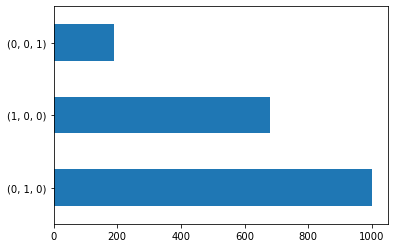

In [9]:
# print out the number of entries per label
labeled_df['label'].value_counts()[:20].plot(kind='barh')

### 5.0.2 Toxicity Data

For prediciting the toxicity score of a tweet, we will use the Toxic Comment Classification dataset [1], containing comments from wikipedia, labeled by their level of toxicity. Before we can use it for training, we have to preprocess it again.

In [10]:
# load the data
toxicity_df = pd.read_csv("toxicity_train.csv")
toxicity_df = toxicity_df.drop("id", axis=1)

# take a look at the data
toxicity_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


We will again transform the labels into encodings. We will work with three levels of toxicity: not toxic, toxic and severly toxic.

In [11]:
def relabel(label):
    # not toxic
    if label == (-1,-1,-1,-1,-1,-1):
        return None
    elif label == (0,0,0,0,0,0):
        return (1,0,0)
    # severely toxic
    elif label[1] or label[3] or label[5]:
        return (0,1,0)
    # toxic
    elif label[0] or label[2] or label[4]:
        return (0,0,1)
    else:
        return (0,0,0)

In [12]:
toxicity_df["label"] = [relabel((toxicity_df.toxic[i], toxicity_df.severe_toxic[i], toxicity_df.obscene[i],
                        toxicity_df.threat[i], toxicity_df.insult[i],
                        toxicity_df.identity_hate[i])) for i in range(len(toxicity_df.toxic))]

We will reuse the previously defined functions for pre-processing.

In [13]:
toxicity_df = toxicity_df.drop(["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"], axis=1)
comments = toxicity_df.comment_text

tokenized_comments = [word_tokenize(clean(comment)) for comment in comments]
tokenized_comments = [remove_stopwords(tokens) for tokens in tokenized_comments]

preprocessed_comments = [" ".join(tokens) for tokens in tokenized_comments]

toxicity_df["text"] = preprocessed_comments

toxicity_train, toxicity_test = train_test_split(toxicity_df, test_size=0.15)

print('Train dataset shape: {}'.format(toxicity_train.shape))
print('Validation dataset shape: {}'.format(toxicity_test.shape))

# convert to numpy array
toxicity_train_text = np.asarray(toxicity_train.comment_text)
toxicity_train_labels = np.asarray([np.asarray(label) for label in toxicity_train.label])

toxicity_test_text = np.asarray(toxicity_test.comment_text)
toxicity_test_labels = np.asarray([np.asarray(label) for label in toxicity_test.label])

Train dataset shape: (135635, 3)
Validation dataset shape: (23936, 3)


### 5.0.3 Final DataFrame
This DataFrame will be used to store the information retrieved from our models.

In [32]:
final_df = pd.DataFrame(columns=["text", "topic", "label", "toxicity"])
final_df["text"] = tweets

## 5.1 The Topic Model
For this task we will utilze the BERTopic library. This library embeds our pre-processed tweets using the BERT model and calculates the topics using hdbscan, a hierarchical version of DBSCAN, and a version of TF-IDF. Further information about BERTopic can be found [here](https://maartengr.github.io/BERTopic/). 


**a) Train the topic model:** Use `.fit_transform` on `topic_model` with our pre-processed tweets as input and save the returned topics and probablities for later use.

In [34]:
topic_model = BERTopic(language="english", min_topic_size=12, calculate_probabilities=True, verbose=True)
print(preprocessed_comments)
# DONE:
topics, probabilities = topic_model.fit_transform(preprocessed_comments)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Batches:   0%|          | 0/4987 [00:00<?, ?it/s]

KeyboardInterrupt: 

Now that we have trained the model, we can take a look at the extracted topics by using different visualizations provided by BERTopic.


**b) Analyse and adjust the topics:** You can find the pre-defined functions [here](https://maartengr.github.io/BERTopic/). You can reduce the amount of topics with `.reduce_topics`, try to find a suitable number of topics for our data.

In [ ]:
# DONE:
topic_model.reduce_topics(preprocessed_comments,topics, nr_topics = 10)

**TODO: Write your observations here**

## 5.2 Text Classification
In this task we will make use of the BERT model and append feed-forward layers for classification.

In [17]:
# small bert
bert_model_handle = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
bert_preprocess_handle = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

### 5.2.1

In this task we will implement the function that builds our classifier.

Below you can see the architecture of our model. Append the missing dense and dropout layers with `keras.layers.Dense` and `keras.layers.Dropout` respectively. For the dropout we will use a value of 0.2 and the dense layers will have 256, 64, 3 neurons.

*Note:* Output corresponds to the last layer and is only present for visualization purposes.

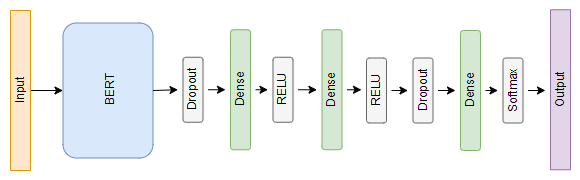

In [36]:
def build_classifier_bert():
    # define the input layer
    text_input = keras.layers.Input(shape=(), dtype=tf.string, name="text")

    # define the preprocessing layer for the BERT model
    preprocessing_layer = hub.KerasLayer(bert_preprocess_handle, name="preprocessing")

    # connect the preprocessing layer to the BERT model
    encoder_inputs = preprocessing_layer(text_input)

    # load the BERT model from tensorflow hub
    encoder = hub.KerasLayer(bert_model_handle, trainable=True, name="BERT_encoder")

    # get the encoder outputs and connect them to our feedforward part
    outputs = encoder(encoder_inputs)
    net = outputs["pooled_output"]

    # DONE:
    dense1 = keras.layers.Dense(256)
    dense2 = keras.layers.Dense(64)
    dense3 = keras.layers.Dense(3)
    dropout = keras.layers.Dropout(0.2)
    
    return keras.Model(text_input, net)

### 5.2.2
Since BERT is a rather large model we will use the GPU to speed up training.


**a) Build the model:** Before we can train the model we have to build it using the previous defined `build_classifier_bert` function. 


**b) Prepare for trianing:** Since we want to predict one-hot encodings of our labels, we will use the `CategoricalCrossentropy` as our loss and the `CategoricalAccuracy` for our metric. You can call them directly from `keras.losses` and `keras.metrics` respectively. Additionally, we want to take a look at the precision and recall during the evaluation. Add the corresponding metrics.


Next we will have to specify the number of epochs and training steps. You can experiment with the number of epochs until you get a satisfying result.


Before we can compile the model, we need to initialize the optimizer. Here we will use a variation of the Adam optimization algorithm that was also used during the training of the BERT model.


Now we can put everything together and compile our model.


**c) Train the model:** Call the `.fit` method on the classifier, use the training set as input and set the correct amount of epochs. If you want to receive information of the training process set `verbose=1`. After the fine-tuning of our model, test it using `.evaluate` and print out the loss and metrics.
 

**d) Predict the labels:** Use the model to predict the labels of our complete dataset. 

In [42]:
with tf.device("/GPU:0"):
    # DONE a.1: build the classifier
    text_classifier = build_classifier_bert()
    
    # DONE a.2: define the loss and metric functions
    loss = keras.losses.CategoricalCrossentropy()
    metrics = keras.metrics.CategoricalAccuracy()
    
    # define epochs and number of training steps
    epochs = 10
    steps_per_epoch = len(train)
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    # define the optimizer
    init_lr = 3e-5
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')

    # compile the model using defined optimizer, loss and metric objects
    text_classifier.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)

    # DONE b: start fine-tuning the model and evaluate it
    text_classifier.fit(train, epochs = epochs)
    text_classifier.evaluate()
    print(loss)
    print(metrics)
    # DONE c: predict the labels of the climate data and add them to final_df
    # Hint: the predictions are returned as vectors of class porbabilities;
    # map the probabilities to the corresponding label
    final_df['label'] = text_classifier.predict(final_df)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

## 5.3 Toxicity predictor
For predicting the toxicity of a tweet we will use the same architecture for our classifier as in the previous task.

**a) Build the classifier, train and evaluate it**

*Hint:* Due to the high amount of training data, less epochs are needed to achieve a good result.

**b) Use the trained classifier for predicting the toxicity labels**

In [43]:
with tf.device("/GPU:0"):
    # DONE a:
    classifier = build_classifier_bert()
    loss = keras.losses.CategoricalCrossentropy()
    metrics = keras.metrics.CategoricalAccuracy()
    
    epochs = 5
    steps_per_epoch = len(train)
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-5
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')

    # compile the model using defined optimizer, loss and metric objects
    classifier.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)

    # DONE b: start fine-tuning the model and evaluate it
    classifier.fit(train, epochs = epochs)
    classifier.evaluate()
    # TODO b: 
    classifier.predict(final_df['label'])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

## 5.4 Analysis of our data
Now that we have all the models we need we can start our analysis.


In [44]:
# take a look at our already gathered data
final_df.head()

,text,topic,label,toxicity
0,law enforcement called these intimidation tact...,NaN,NaN,NaN
1,without our forests we will be dragged well be...,NaN,NaN,NaN
2,"more pcs are getting windows 11, is yours next...",NaN,NaN,NaN
3,this is what unelected @potus want 🇺🇸 on the g...,NaN,NaN,NaN
4,“..a..notorious switch to sunderland where an ...,NaN,NaN,NaN


In [45]:
def from_vector(v):
    if v == "not toxic":
        return 0
    elif v == "toxic":
        return 0.5
    else:
        return 1

**a) Calculate the average toxicity per topic:** Iterate over all topics and calculate their average toxicity, the average toxicity per label and the share of the labels.

In [52]:
by_topic = pd.DataFrame(columns=["num_activists", "avg_toxicity_activists",
                                 "num_neutrals", "avg_toxicity_neutrals",
                                 "num_deniers", "avg_toxicity_deniers",
                                 "avg_toxicity"])

num_topics = final_df["topic"].nunique()-1

# TODO:
for topic in by_topic:
    
by_topic


-1


,num_activists,avg_toxicity_activists,num_neutrals,avg_toxicity_neutrals,num_deniers,avg_toxicity_deniers,avg_toxicity


**b) Visualize the average toxicity by topic:** Try to find good visualizations. 
Examples:
* Use a bar plot for `by_topic`, you can also drop the share of labels per topic, to get a better overview
* Sort topics by their toxicity and plot them

<BarContainer object of 0 artists>

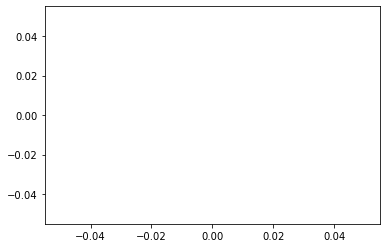

In [56]:
# TODO:
import matplotlib
matplotlib.pyplot.bar(by_topic,num_topics)

**c) Visualize the overall toxicity and by label**

In [ ]:
# TODO:

**d)** Discuss the visualizations and try to make assumptions based on these. Which group is more toxic and why? What are the distributions among the data? Are there topics dominated by certain groups?

# References

[1] https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge